In [1]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import random
from sklearn.utils import shuffle
import scipy.stats
from zipfile import ZipFile 
import optuna
from sklearn.model_selection import train_test_split

2024-04-26 23:20:08.609226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 23:20:09.258783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import time
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np

In [3]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [4]:
def process_eeg_data(x, y):
    new_x =[]
    new_y = []
    split_size = 178
    n_splits = 23
    for i in range(x.shape[0]):
        sub_data = x[i]
        y_val = y[i]
        for i in range (n_splits):
            sample = sub_data[i*split_size:(i+1)*split_size]
            new_x.append(sample)
            temp_y = y_val
            new_y.append(temp_y)
            #print(sample.shape)
            
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    # x = new_x
    # y = new_y
    return new_x, new_y

In [5]:
def load_eeg_data():
    input_dir = 'eeg_dataset_1/'
    x_train = np.load(input_dir +'x_train.npy')
    x_validation = np.load(input_dir +'x_valid.npy')
    x_test = np.load(input_dir +'x_test.npy')
    y_train = np.load(input_dir +'y_train.npy')
    y_validation = np.load(input_dir +'y_valid.npy')
    y_test = np.load(input_dir +'y_test.npy')
    
    x_train = x_train.astype(float)
    x_validation = x_validation.astype(float)
    x_test = x_test.astype(float)
    
    x_train, y_train = process_eeg_data(x_train, y_train)
    x_validation, y_validation = process_eeg_data(x_validation, y_validation)
    x_test, y_test = process_eeg_data(x_test, y_test)
    
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [6]:
x_train, y_train, x_validate, y_validate, x_test, y_test \
                             = load_eeg_data()

In [7]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[2], x_train.shape[1])
x_validate = x_validate.reshape(x_validate.shape[0], x_validate.shape[2], x_validate.shape[1])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[2], x_test.shape[1])
print(x_train.shape, y_train.shape)
print(x_validate.shape, y_validate.shape)
print(x_test.shape, y_test.shape)

(6900, 1, 178) (6900, 2)
(2300, 1, 178) (2300, 2)
(2300, 1, 178) (2300, 2)


In [8]:
def lstm_model_1(x_train, y_train, n_units):
    n_features, n_timesteps, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    
    model = keras.Sequential(
        [
            keras.Input(shape=(n_features, n_timesteps)),
            # layers.LSTM(n_units, return_sequences=True, activation='relu'),
            # layers.Dropout(0.1),
            layers.LSTM(n_units, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(100, activation='relu'),
            layers.Dense(n_outputs, activation='softmax')
        ]
    )
    return model

In [9]:
units_arr = [10, 20, 30, 50, 100, 200, 500, 1000]
BATCH_SIZE = 32     # Typical values are 8, 16 or 32
NUM_EPOCHS = 30
val_acc_arr = []
pred_acc_arr = []
time_arr = []
keras.backend.clear_session()
for n_units in units_arr:
    model = lstm_model_1(x_train, y_train, n_units)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    print(model.summary())
    start = time.time()
    history = model.fit(
            x_train,y_train,
            steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=(x_validate,y_validate),
            validation_steps=x_validate.shape[0]//BATCH_SIZE)
    
    print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
    end = time.time()
    predictions = model.predict(x_test, verbose=0,batch_size=32)
    
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
    
    # Print print prediction accuracy
    print('Num units: ',n_units)
    print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    print('Time in sec: ' ,end-start)
    val_acc_arr.append(history.history['val_accuracy'][-1])
    pred_acc_arr.append(accuracy_score(y_test_act, y_pred))
    time_arr.append(end-start)
    
    keras.backend.clear_session()

2024-04-26 23:20:22.214567: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │         7,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,862 (34.62 KB)

 Trainable params: 8,862 (34.62 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
199/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7069 - loss: 4.0971

2024-04-26 23:20:23.530260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7090 - loss: 3.9307 - val_accuracy: 0.8104 - val_loss: 0.5614
Epoch 2/30
166/215 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8059 - loss: 0.5638

2024-04-26 23:20:23.739536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8062 - loss: 0.5642 - val_accuracy: 0.8348 - val_loss: 0.5000
Epoch 3/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.8527 - loss: 0.4201

2024-04-26 23:20:23.974310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:24.027751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8500 - loss: 0.4269 - val_accuracy: 0.8396 - val_loss: 0.4829
Epoch 4/30
101/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8467 - loss: 0.4171

2024-04-26 23:20:24.257434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:24.312296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8501 - loss: 0.4161 - val_accuracy: 0.8391 - val_loss: 0.4677
Epoch 5/30
112/215 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8535 - loss: 0.4219

2024-04-26 23:20:24.557316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:24.610242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8556 - loss: 0.4149 - val_accuracy: 0.8278 - val_loss: 0.5289
Epoch 6/30
115/215 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.8566 - loss: 0.4028

2024-04-26 23:20:24.838924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:24.887776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8568 - loss: 0.4010 - val_accuracy: 0.8478 - val_loss: 0.4290
Epoch 7/30
118/215 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.8699 - loss: 0.3989

2024-04-26 23:20:25.108577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:25.162366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8706 - loss: 0.3892 - val_accuracy: 0.8509 - val_loss: 0.4554
Epoch 8/30
102/215 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8673 - loss: 0.3808

2024-04-26 23:20:25.384214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:25.437817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8672 - loss: 0.3833 - val_accuracy: 0.8630 - val_loss: 0.3907
Epoch 9/30
104/215 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.8733 - loss: 0.3811

2024-04-26 23:20:25.673004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:25.724197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8731 - loss: 0.3813 - val_accuracy: 0.8783 - val_loss: 0.3651
Epoch 10/30
108/215 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8872 - loss: 0.3236

2024-04-26 23:20:25.960875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:26.015954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8849 - loss: 0.3416 - val_accuracy: 0.8552 - val_loss: 0.4258
Epoch 11/30
 49/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8720 - loss: 0.4391 

2024-04-26 23:20:26.244472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:26.304722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8762 - loss: 0.4282 - val_accuracy: 0.8783 - val_loss: 0.3546
Epoch 12/30
114/215 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.8773 - loss: 0.3476

2024-04-26 23:20:26.547374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:26.599248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8818 - loss: 0.3475 - val_accuracy: 0.8713 - val_loss: 0.4210
Epoch 13/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.8822 - loss: 0.3445

2024-04-26 23:20:26.828326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:26.878938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8833 - loss: 0.3505 - val_accuracy: 0.8630 - val_loss: 0.4553
Epoch 14/30
105/215 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.8978 - loss: 0.3185

2024-04-26 23:20:27.089275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:27.144230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8980 - loss: 0.3174 - val_accuracy: 0.8696 - val_loss: 0.3840
Epoch 15/30
 51/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8896 - loss: 0.3075 

2024-04-26 23:20:27.387676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:27.444370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8874 - loss: 0.3265 - val_accuracy: 0.8600 - val_loss: 0.6652
Epoch 16/30
 98/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8765 - loss: 0.4007

2024-04-26 23:20:27.714620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:27.773186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8833 - loss: 0.3742 - val_accuracy: 0.8883 - val_loss: 0.3327
Epoch 17/30
105/215 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9139 - loss: 0.2886

2024-04-26 23:20:28.018311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:28.071480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9078 - loss: 0.3091 - val_accuracy: 0.8770 - val_loss: 0.3843
Epoch 18/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8936 - loss: 0.3423

2024-04-26 23:20:28.312781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:28.368450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8959 - loss: 0.3327 - val_accuracy: 0.8896 - val_loss: 0.3419
Epoch 19/30
 49/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9027 - loss: 0.2970 

2024-04-26 23:20:28.637619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:28.698342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9029 - loss: 0.2969 - val_accuracy: 0.8870 - val_loss: 0.3522
Epoch 20/30
118/215 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9047 - loss: 0.3085

2024-04-26 23:20:28.934380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:28.984514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9040 - loss: 0.3062 - val_accuracy: 0.8752 - val_loss: 0.3733
Epoch 21/30
 56/215 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.9046 - loss: 0.2843

2024-04-26 23:20:29.205097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:29.260557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9048 - loss: 0.2987 - val_accuracy: 0.8678 - val_loss: 0.5554
Epoch 22/30
 50/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8916 - loss: 0.4120 

2024-04-26 23:20:29.508794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:29.570665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8950 - loss: 0.3517 - val_accuracy: 0.8843 - val_loss: 0.3633
Epoch 23/30
 54/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9088 - loss: 0.2843

2024-04-26 23:20:29.815082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:29.879666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9065 - loss: 0.2906 - val_accuracy: 0.8761 - val_loss: 0.3795
Epoch 24/30
106/215 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.9108 - loss: 0.2814

2024-04-26 23:20:30.110038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:30.165346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9080 - loss: 0.2971 - val_accuracy: 0.8917 - val_loss: 0.3512
Epoch 25/30
 27/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9208 - loss: 0.2587 

2024-04-26 23:20:30.405320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:30.463629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9163 - loss: 0.2637 - val_accuracy: 0.8887 - val_loss: 0.3635
Epoch 26/30
 50/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9123 - loss: 0.2759 

2024-04-26 23:20:30.747694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:30.811305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9069 - loss: 0.3014 - val_accuracy: 0.8991 - val_loss: 0.3308
Epoch 27/30
104/215 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.9179 - loss: 0.2637

2024-04-26 23:20:31.063737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:31.119442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9154 - loss: 0.2712 - val_accuracy: 0.9039 - val_loss: 0.3244
Epoch 28/30
 39/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8942 - loss: 0.3665 

2024-04-26 23:20:31.366335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:31.449376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9072 - loss: 0.3027 - val_accuracy: 0.9078 - val_loss: 0.3093
Epoch 29/30
 40/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9254 - loss: 0.2348 

2024-04-26 23:20:31.758720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:31.827756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9161 - loss: 0.2601 - val_accuracy: 0.9096 - val_loss: 0.2868
Epoch 30/30
 43/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9162 - loss: 0.2706 

2024-04-26 23:20:32.137556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:32.201725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9172 - loss: 0.2677 - val_accuracy: 0.9126 - val_loss: 0.2818
Final Validation Accuracy: 0.913


2024-04-26 23:20:32.487062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:32.539930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  10
Prediction accuracy: 0.907
Time in sec:  10.282740831375122


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │        15,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,222 (71.18 KB)

 Trainable params: 18,222 (71.18 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
203/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6053 - loss: 7.7948 

2024-04-26 23:20:34.195196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6069 - loss: 7.5856 - val_accuracy: 0.7309 - val_loss: 1.3670
Epoch 2/30
158/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.7622 - loss: 0.9830

2024-04-26 23:20:34.402827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7690 - loss: 0.9543 - val_accuracy: 0.8161 - val_loss: 0.8729
Epoch 3/30
107/215 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.8233 - loss: 0.5946

2024-04-26 23:20:34.648828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:34.703496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8299 - loss: 0.5674 - val_accuracy: 0.8091 - val_loss: 0.7365
Epoch 4/30
106/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.8552 - loss: 0.4954

2024-04-26 23:20:34.946055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:34.996437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8563 - loss: 0.4895 - val_accuracy: 0.8383 - val_loss: 0.5874
Epoch 5/30
 52/215 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.8830 - loss: 0.3773

2024-04-26 23:20:35.232860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:35.285832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8745 - loss: 0.4037 - val_accuracy: 0.8622 - val_loss: 0.4948
Epoch 6/30
106/215 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8795 - loss: 0.3660

2024-04-26 23:20:35.559648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:35.614700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8797 - loss: 0.3629 - val_accuracy: 0.8687 - val_loss: 0.5112
Epoch 7/30
105/215 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.8834 - loss: 0.3519

2024-04-26 23:20:35.855293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:35.908856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8842 - loss: 0.3488 - val_accuracy: 0.8635 - val_loss: 0.5263
Epoch 8/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.8854 - loss: 0.3959

2024-04-26 23:20:36.147109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:36.199679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8871 - loss: 0.3881 - val_accuracy: 0.8765 - val_loss: 0.4134
Epoch 9/30
 39/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9124 - loss: 0.2854 

2024-04-26 23:20:36.443621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:36.505211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8989 - loss: 0.3196 - val_accuracy: 0.8804 - val_loss: 0.3795
Epoch 10/30
 82/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9068 - loss: 0.2866

2024-04-26 23:20:36.816436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:36.874395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9050 - loss: 0.2979 - val_accuracy: 0.8952 - val_loss: 0.3972
Epoch 11/30
 97/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9148 - loss: 0.2623

2024-04-26 23:20:37.152384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:37.205817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9113 - loss: 0.2720 - val_accuracy: 0.8683 - val_loss: 0.4236
Epoch 12/30
 86/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9207 - loss: 0.2478

2024-04-26 23:20:37.464386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:37.518781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9193 - loss: 0.2521 - val_accuracy: 0.8904 - val_loss: 0.3453
Epoch 13/30
 86/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9334 - loss: 0.2125

2024-04-26 23:20:37.804480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:37.863091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9286 - loss: 0.2250 - val_accuracy: 0.8891 - val_loss: 0.3598
Epoch 14/30
 41/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9268 - loss: 0.2219 

2024-04-26 23:20:38.146377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:38.208297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9210 - loss: 0.2483 - val_accuracy: 0.8883 - val_loss: 0.3657
Epoch 15/30
 41/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9319 - loss: 0.2149 

2024-04-26 23:20:38.511611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:38.573885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9208 - loss: 0.2558 - val_accuracy: 0.8839 - val_loss: 0.4088
Epoch 16/30
 40/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9122 - loss: 0.3074 

2024-04-26 23:20:38.876186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:38.934616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9092 - loss: 0.3287 - val_accuracy: 0.8996 - val_loss: 0.3287
Epoch 17/30
 41/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9220 - loss: 0.2642 

2024-04-26 23:20:39.238006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:39.294259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9191 - loss: 0.2690 - val_accuracy: 0.8943 - val_loss: 0.3654
Epoch 18/30
 42/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9218 - loss: 0.2334 

2024-04-26 23:20:39.595958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:39.660366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9250 - loss: 0.2392 - val_accuracy: 0.9048 - val_loss: 0.3341
Epoch 19/30
 43/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9276 - loss: 0.2531 

2024-04-26 23:20:39.949806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:40.012299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9253 - loss: 0.2706 - val_accuracy: 0.8761 - val_loss: 0.4549
Epoch 20/30
104/215 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.9162 - loss: 0.2759

2024-04-26 23:20:40.290208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:40.350355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9164 - loss: 0.2864 - val_accuracy: 0.8870 - val_loss: 0.4194
Epoch 21/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9274 - loss: 0.2671

2024-04-26 23:20:40.593333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:40.647818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9248 - loss: 0.2723 - val_accuracy: 0.8743 - val_loss: 0.4528
Epoch 22/30
121/215 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.9137 - loss: 0.2797

2024-04-26 23:20:40.858869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:40.911449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9137 - loss: 0.2833 - val_accuracy: 0.8983 - val_loss: 0.3315
Epoch 23/30
 93/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9188 - loss: 0.2615

2024-04-26 23:20:41.123804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:41.171813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9216 - loss: 0.2556 - val_accuracy: 0.8935 - val_loss: 0.3511
Epoch 24/30
101/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9398 - loss: 0.2118

2024-04-26 23:20:41.430793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:41.488380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9345 - loss: 0.2402 - val_accuracy: 0.8900 - val_loss: 0.4163
Epoch 25/30
121/215 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.9346 - loss: 0.2848

2024-04-26 23:20:41.742776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:41.795219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9321 - loss: 0.2777 - val_accuracy: 0.8770 - val_loss: 0.4621
Epoch 26/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.9273 - loss: 0.2537

2024-04-26 23:20:42.017233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:42.071286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9295 - loss: 0.2444 - val_accuracy: 0.9022 - val_loss: 0.3227
Epoch 27/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.9310 - loss: 0.2379

2024-04-26 23:20:42.301038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:42.351195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9335 - loss: 0.2296 - val_accuracy: 0.8896 - val_loss: 0.3824
Epoch 28/30
 90/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9317 - loss: 0.2487

2024-04-26 23:20:42.588928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:42.648849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9320 - loss: 0.2449 - val_accuracy: 0.8861 - val_loss: 0.3765
Epoch 29/30
 43/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9326 - loss: 0.2229 

2024-04-26 23:20:42.923915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:42.982324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9373 - loss: 0.2108 - val_accuracy: 0.8909 - val_loss: 0.3853
Epoch 30/30
 55/215 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.9272 - loss: 0.2951

2024-04-26 23:20:43.273887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:43.330365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9267 - loss: 0.2916 - val_accuracy: 0.8987 - val_loss: 0.3455
Final Validation Accuracy: 0.899


2024-04-26 23:20:43.581209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:43.631249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  20
Prediction accuracy: 0.904
Time in sec:  10.629135131835938


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30)             │        25,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,382 (110.87 KB)

 Trainable params: 28,382 (110.87 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
179/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5626 - loss: 5.6082

2024-04-26 23:20:45.383549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5704 - loss: 5.2772 - val_accuracy: 0.7165 - val_loss: 1.6873
Epoch 2/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7705 - loss: 1.1615

2024-04-26 23:20:45.602397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7751 - loss: 1.1249 - val_accuracy: 0.7922 - val_loss: 0.8635
Epoch 3/30
 44/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8260 - loss: 0.6315 

2024-04-26 23:20:45.944869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:46.010258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8381 - loss: 0.6140 - val_accuracy: 0.8270 - val_loss: 0.6652
Epoch 4/30
100/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8929 - loss: 0.3733

2024-04-26 23:20:46.289093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:46.346262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8877 - loss: 0.3848 - val_accuracy: 0.8383 - val_loss: 0.6228
Epoch 5/30
106/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.8898 - loss: 0.3841

2024-04-26 23:20:46.600233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:46.658443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8895 - loss: 0.3823 - val_accuracy: 0.8509 - val_loss: 0.5783
Epoch 6/30
113/215 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.8875 - loss: 0.3668

2024-04-26 23:20:46.898811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:46.954094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8912 - loss: 0.3616 - val_accuracy: 0.8622 - val_loss: 0.5084
Epoch 7/30
100/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9155 - loss: 0.3003

2024-04-26 23:20:47.182520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:47.238189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9107 - loss: 0.3095 - val_accuracy: 0.8578 - val_loss: 0.5242
Epoch 8/30
102/215 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.9043 - loss: 0.3041

2024-04-26 23:20:47.492368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:47.552029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9057 - loss: 0.3076 - val_accuracy: 0.8713 - val_loss: 0.4683
Epoch 9/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.9191 - loss: 0.2645

2024-04-26 23:20:47.796366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:47.850372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9198 - loss: 0.2709 - val_accuracy: 0.8761 - val_loss: 0.4337
Epoch 10/30
 56/215 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.9115 - loss: 0.3295

2024-04-26 23:20:48.078919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:48.130096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9130 - loss: 0.3096 - val_accuracy: 0.8735 - val_loss: 0.4127
Epoch 11/30
103/215 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.9329 - loss: 0.2425

2024-04-26 23:20:48.391899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:48.449660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9320 - loss: 0.2419 - val_accuracy: 0.8796 - val_loss: 0.4137
Epoch 12/30
107/215 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.9345 - loss: 0.2409

2024-04-26 23:20:48.696042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:48.748332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9284 - loss: 0.2510 - val_accuracy: 0.8800 - val_loss: 0.5094
Epoch 13/30
106/215 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.9309 - loss: 0.2666

2024-04-26 23:20:48.987896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:49.043412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9312 - loss: 0.2549 - val_accuracy: 0.8891 - val_loss: 0.3912
Epoch 14/30
 48/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9393 - loss: 0.2490 

2024-04-26 23:20:49.287372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:49.356750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9355 - loss: 0.2460 - val_accuracy: 0.8843 - val_loss: 0.3800
Epoch 15/30
118/215 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.9295 - loss: 0.2527

2024-04-26 23:20:49.605878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:49.662998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9303 - loss: 0.2523 - val_accuracy: 0.8904 - val_loss: 0.3838
Epoch 16/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9364 - loss: 0.2213

2024-04-26 23:20:49.885083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:49.942735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9350 - loss: 0.2372 - val_accuracy: 0.8935 - val_loss: 0.3651
Epoch 17/30
100/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9429 - loss: 0.1982

2024-04-26 23:20:50.199435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:50.258873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9388 - loss: 0.2120 - val_accuracy: 0.8878 - val_loss: 0.3996
Epoch 18/30
 51/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9351 - loss: 0.2248 

2024-04-26 23:20:50.511159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:50.582025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9335 - loss: 0.2296 - val_accuracy: 0.8939 - val_loss: 0.3460
Epoch 19/30
116/215 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9387 - loss: 0.2132

2024-04-26 23:20:50.831944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:50.885744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9362 - loss: 0.2237 - val_accuracy: 0.9043 - val_loss: 0.3468
Epoch 20/30
 49/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9471 - loss: 0.2001 

2024-04-26 23:20:51.111475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:51.171176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9387 - loss: 0.2207 - val_accuracy: 0.8887 - val_loss: 0.3982
Epoch 21/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.9500 - loss: 0.1642

2024-04-26 23:20:51.435217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:51.489837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9458 - loss: 0.1813 - val_accuracy: 0.8870 - val_loss: 0.3694
Epoch 22/30
114/215 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.9344 - loss: 0.2126

2024-04-26 23:20:51.724617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:51.776455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9329 - loss: 0.2224 - val_accuracy: 0.8935 - val_loss: 0.3945
Epoch 23/30
116/215 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.9441 - loss: 0.1897

2024-04-26 23:20:52.004309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:52.055072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9411 - loss: 0.2035 - val_accuracy: 0.9017 - val_loss: 0.3728
Epoch 24/30
104/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.9327 - loss: 0.2661

2024-04-26 23:20:52.277482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:52.329438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9323 - loss: 0.2630 - val_accuracy: 0.8843 - val_loss: 0.4055
Epoch 25/30
105/215 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9501 - loss: 0.1799

2024-04-26 23:20:52.575557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:52.636675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9447 - loss: 0.2102 - val_accuracy: 0.8926 - val_loss: 0.3905
Epoch 26/30
101/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.1881  

2024-04-26 23:20:52.876775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:52.934512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.1984 - val_accuracy: 0.8930 - val_loss: 0.3819
Epoch 27/30
109/215 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9406 - loss: 0.2818

2024-04-26 23:20:53.182402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:53.234535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9365 - loss: 0.2778 - val_accuracy: 0.8552 - val_loss: 0.5421
Epoch 28/30
 90/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9287 - loss: 0.2319

2024-04-26 23:20:53.469065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:53.520801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9333 - loss: 0.2226 - val_accuracy: 0.8948 - val_loss: 0.3578
Epoch 29/30
106/215 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.9370 - loss: 0.2167

2024-04-26 23:20:53.800601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:53.855103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9401 - loss: 0.2106 - val_accuracy: 0.9048 - val_loss: 0.3360
Epoch 30/30
 58/215 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.9339 - loss: 0.2458

2024-04-26 23:20:54.097236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:54.152336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9350 - loss: 0.2400 - val_accuracy: 0.9078 - val_loss: 0.3060
Final Validation Accuracy: 0.908


2024-04-26 23:20:54.379259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:54.429316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  30
Prediction accuracy: 0.921
Time in sec:  10.303154230117798


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        45,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,102 (199.62 KB)

 Trainable params: 51,102 (199.62 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
191/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6380 - loss: 5.6449

2024-04-26 23:20:56.125554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6395 - loss: 5.4329 - val_accuracy: 0.7687 - val_loss: 2.9283
Epoch 2/30
159/215 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.7568 - loss: 1.5747

2024-04-26 23:20:56.339831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7581 - loss: 1.5547 - val_accuracy: 0.7722 - val_loss: 1.3006
Epoch 3/30
 45/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8066 - loss: 0.8201 

2024-04-26 23:20:56.583545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:56.641217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8217 - loss: 0.8173 - val_accuracy: 0.8252 - val_loss: 0.9738
Epoch 4/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8812 - loss: 0.4704 

2024-04-26 23:20:56.917477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:56.981644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.5129 - val_accuracy: 0.8391 - val_loss: 0.7818
Epoch 5/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8952 - loss: 0.4635 

2024-04-26 23:20:57.308049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:57.370772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8999 - loss: 0.4018 - val_accuracy: 0.8613 - val_loss: 0.7086
Epoch 6/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8988 - loss: 0.3812 

2024-04-26 23:20:57.734771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:57.804512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9053 - loss: 0.3460 - val_accuracy: 0.8570 - val_loss: 0.5585
Epoch 7/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9052 - loss: 0.5917 

2024-04-26 23:20:58.142126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:58.201521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9073 - loss: 0.4420 - val_accuracy: 0.8630 - val_loss: 0.6930
Epoch 8/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9350 - loss: 0.2589 

2024-04-26 23:20:58.540585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:58.608894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9261 - loss: 0.2687 - val_accuracy: 0.8752 - val_loss: 0.5581
Epoch 9/30
 40/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9289 - loss: 0.2707 

2024-04-26 23:20:58.946724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:59.016251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9312 - loss: 0.2681 - val_accuracy: 0.8578 - val_loss: 0.5965
Epoch 10/30
 41/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9280 - loss: 0.2714 

2024-04-26 23:20:59.353170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:59.420055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 0.2485 - val_accuracy: 0.8909 - val_loss: 0.4375
Epoch 11/30
 40/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9446 - loss: 0.1946 

2024-04-26 23:20:59.726651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:20:59.788480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9423 - loss: 0.2114 - val_accuracy: 0.8852 - val_loss: 0.4524
Epoch 12/30
 38/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9417 - loss: 0.1935  

2024-04-26 23:21:00.090137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:00.154497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9428 - loss: 0.2112 - val_accuracy: 0.8670 - val_loss: 0.5951
Epoch 13/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9220 - loss: 0.2970 

2024-04-26 23:21:00.516005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:00.581340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9314 - loss: 0.2705 - val_accuracy: 0.8865 - val_loss: 0.4986
Epoch 14/30
 34/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9519 - loss: 0.1906 

2024-04-26 23:21:00.932843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:01.004800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9408 - loss: 0.2295 - val_accuracy: 0.8939 - val_loss: 0.4136
Epoch 15/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9528 - loss: 0.1695 

2024-04-26 23:21:01.372185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:01.444432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9519 - loss: 0.1836 - val_accuracy: 0.9052 - val_loss: 0.3736
Epoch 16/30
 83/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9527 - loss: 0.1501

2024-04-26 23:21:01.782231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:01.840118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9510 - loss: 0.1716 - val_accuracy: 0.9017 - val_loss: 0.3488
Epoch 17/30
 82/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9691 - loss: 0.1191

2024-04-26 23:21:02.137879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:02.198250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1470 - val_accuracy: 0.8935 - val_loss: 0.3887
Epoch 18/30
 80/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9524 - loss: 0.1556

2024-04-26 23:21:02.494545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:02.553776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9506 - loss: 0.1738 - val_accuracy: 0.9061 - val_loss: 0.3849
Epoch 19/30
 89/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9595 - loss: 0.1438

2024-04-26 23:21:02.854890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:02.912499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9553 - loss: 0.1637 - val_accuracy: 0.9052 - val_loss: 0.3524
Epoch 20/30
 45/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9565 - loss: 0.1761 

2024-04-26 23:21:03.192233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:03.254637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9559 - loss: 0.1728 - val_accuracy: 0.8957 - val_loss: 0.4027
Epoch 21/30
 85/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9602 - loss: 0.1275

2024-04-26 23:21:03.528405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:03.584803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9595 - loss: 0.1386 - val_accuracy: 0.9009 - val_loss: 0.3311
Epoch 22/30
 48/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9642 - loss: 0.1403 

2024-04-26 23:21:03.872655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:03.938192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9604 - loss: 0.1513 - val_accuracy: 0.8917 - val_loss: 0.3722
Epoch 23/30
 87/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9652 - loss: 0.1483

2024-04-26 23:21:04.197034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:04.252309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9649 - loss: 0.1420 - val_accuracy: 0.9074 - val_loss: 0.3209
Epoch 24/30
 87/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9702 - loss: 0.1261

2024-04-26 23:21:04.530156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:04.585713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9662 - loss: 0.1387 - val_accuracy: 0.9009 - val_loss: 0.3597
Epoch 25/30
 79/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9630 - loss: 0.1216

2024-04-26 23:21:04.871513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:04.928299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9623 - loss: 0.1358 - val_accuracy: 0.9187 - val_loss: 0.3121
Epoch 26/30
 46/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9662 - loss: 0.1378 

2024-04-26 23:21:05.238322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:05.301102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9669 - loss: 0.1316 - val_accuracy: 0.9130 - val_loss: 0.2927
Epoch 27/30
 94/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9727 - loss: 0.0985

2024-04-26 23:21:05.570537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:05.624008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9693 - loss: 0.1089 - val_accuracy: 0.9109 - val_loss: 0.3171
Epoch 28/30
 41/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9731 - loss: 0.0940 

2024-04-26 23:21:05.889590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:05.951202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9664 - loss: 0.1284 - val_accuracy: 0.9104 - val_loss: 0.3218
Epoch 29/30
 40/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9696 - loss: 0.0974 

2024-04-26 23:21:06.268670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:06.334318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9639 - loss: 0.1209 - val_accuracy: 0.9200 - val_loss: 0.2984
Epoch 30/30
 38/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9778 - loss: 0.1029 

2024-04-26 23:21:06.648536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:06.713695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1372 - val_accuracy: 0.9104 - val_loss: 0.3424
Final Validation Accuracy: 0.910


2024-04-26 23:21:07.030059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:07.088170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  50
Prediction accuracy: 0.938
Time in sec:  12.20218539237976


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │       111,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,902 (476.18 KB)

 Trainable params: 121,902 (476.18 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
186/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6579 - loss: 6.3246

2024-04-26 23:21:08.947222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6621 - loss: 6.0600 - val_accuracy: 0.7335 - val_loss: 3.4437
Epoch 2/30
 87/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 1.7737

2024-04-26 23:21:09.178999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 1.7683 - val_accuracy: 0.7978 - val_loss: 2.1390
Epoch 3/30
 30/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - loss: 0.8614 

2024-04-26 23:21:09.600560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:09.679324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8404 - loss: 1.0343 - val_accuracy: 0.7857 - val_loss: 1.6044
Epoch 4/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8929 - loss: 0.6843 

2024-04-26 23:21:10.079196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:10.148577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8648 - loss: 0.7507 - val_accuracy: 0.8213 - val_loss: 1.3032
Epoch 5/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8826 - loss: 0.4664 

2024-04-26 23:21:10.506136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:10.569654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8927 - loss: 0.4765 - val_accuracy: 0.8226 - val_loss: 1.0432
Epoch 6/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9015 - loss: 0.2941 

2024-04-26 23:21:10.928609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:10.995712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9168 - loss: 0.2980 - val_accuracy: 0.8587 - val_loss: 0.8868
Epoch 7/30
 37/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9575 - loss: 0.2068 

2024-04-26 23:21:11.345810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:11.405492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9384 - loss: 0.2433 - val_accuracy: 0.8448 - val_loss: 0.8270
Epoch 8/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9588 - loss: 0.1818 

2024-04-26 23:21:11.732364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:11.793625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9455 - loss: 0.2247 - val_accuracy: 0.8678 - val_loss: 0.8757
Epoch 9/30
 33/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9551 - loss: 0.1846 

2024-04-26 23:21:12.172424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:12.240023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9504 - loss: 0.2287 - val_accuracy: 0.8778 - val_loss: 0.7246
Epoch 10/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9544 - loss: 0.1495 

2024-04-26 23:21:12.591941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:12.659789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9469 - loss: 0.1947 - val_accuracy: 0.8509 - val_loss: 0.7165
Epoch 11/30
 30/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9117 - loss: 0.3910 

2024-04-26 23:21:13.004153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:13.069845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9323 - loss: 0.3008 - val_accuracy: 0.8765 - val_loss: 0.6257
Epoch 12/30
 33/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.3125 

2024-04-26 23:21:13.462194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:13.528057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9487 - loss: 0.2445 - val_accuracy: 0.8600 - val_loss: 0.6559
Epoch 13/30
 33/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1180 

2024-04-26 23:21:13.894529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:13.959981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9614 - loss: 0.1507 - val_accuracy: 0.8787 - val_loss: 0.5512
Epoch 14/30
 33/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9672 - loss: 0.1154 

2024-04-26 23:21:14.325893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:14.408305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9607 - loss: 0.1481 - val_accuracy: 0.8891 - val_loss: 0.4912
Epoch 15/30
 37/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9577 - loss: 0.2953 

2024-04-26 23:21:14.771956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:14.834173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9608 - loss: 0.1933 - val_accuracy: 0.8987 - val_loss: 0.4785
Epoch 16/30
 38/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9753 - loss: 0.0802 

2024-04-26 23:21:15.167994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:15.229996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.0971 - val_accuracy: 0.8861 - val_loss: 0.4739
Epoch 17/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9645 - loss: 0.1067 

2024-04-26 23:21:15.568837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:15.634541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9664 - loss: 0.1105 - val_accuracy: 0.8817 - val_loss: 0.4547
Epoch 18/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9708 - loss: 0.1077 

2024-04-26 23:21:15.984444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:16.046120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9672 - loss: 0.1218 - val_accuracy: 0.8991 - val_loss: 0.4562
Epoch 19/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9760 - loss: 0.0862 

2024-04-26 23:21:16.384518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:16.446823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 0.1027 - val_accuracy: 0.9043 - val_loss: 0.3806
Epoch 20/30
 35/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9783 - loss: 0.0956 

2024-04-26 23:21:16.775516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:16.863279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9730 - loss: 0.1131 - val_accuracy: 0.9139 - val_loss: 0.4017
Epoch 21/30
 33/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9635 - loss: 0.1308 

2024-04-26 23:21:17.206577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:17.273606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.1216 - val_accuracy: 0.9039 - val_loss: 0.3442
Epoch 22/30
 19/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9604 - loss: 0.1864 

2024-04-26 23:21:17.632031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:17.696286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9698 - loss: 0.1177 - val_accuracy: 0.9096 - val_loss: 0.3404
Epoch 23/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9651 - loss: 0.1101 

2024-04-26 23:21:18.065413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:18.128822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9691 - loss: 0.1004 - val_accuracy: 0.9183 - val_loss: 0.3165
Epoch 24/30
 30/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9706 - loss: 0.0965 

2024-04-26 23:21:18.518755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:18.594745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.1051 - val_accuracy: 0.9274 - val_loss: 0.2512
Epoch 25/30
 33/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0617 

2024-04-26 23:21:19.006425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:19.074846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0644 - val_accuracy: 0.9252 - val_loss: 0.2636
Epoch 26/30
 31/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0391 

2024-04-26 23:21:19.445114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:19.515962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0624 - val_accuracy: 0.9270 - val_loss: 0.2620
Epoch 27/30
 32/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0562 

2024-04-26 23:21:19.900286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:19.972830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.0697 - val_accuracy: 0.9209 - val_loss: 0.2954
Epoch 28/30
 30/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.1014 

2024-04-26 23:21:20.360608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:20.432029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9760 - loss: 0.0952 - val_accuracy: 0.9330 - val_loss: 0.2407
Epoch 29/30
 33/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.1254 

2024-04-26 23:21:20.819753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:20.890890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.1002 - val_accuracy: 0.9243 - val_loss: 0.2940
Epoch 30/30
 32/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9812 - loss: 0.0968 

2024-04-26 23:21:21.279378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:21.347806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9769 - loss: 0.0955 - val_accuracy: 0.9183 - val_loss: 0.2783
Final Validation Accuracy: 0.918


2024-04-26 23:21:21.729759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:21.802964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  100
Prediction accuracy: 0.937
Time in sec:  14.21000051498413


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       303,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,502 (1.23 MB)

 Trainable params: 323,502 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
185/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7145 - loss: 6.3490

2024-04-26 23:21:23.858768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7160 - loss: 6.0633 - val_accuracy: 0.7313 - val_loss: 3.2069
Epoch 2/30
 76/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8016 - loss: 1.5975

2024-04-26 23:21:24.086571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8097 - loss: 1.5677 - val_accuracy: 0.7796 - val_loss: 2.1126
Epoch 3/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8472 - loss: 0.9690 

2024-04-26 23:21:24.557548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:24.629218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8504 - loss: 1.0996 - val_accuracy: 0.7978 - val_loss: 1.7545
Epoch 4/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9090 - loss: 0.6134 

2024-04-26 23:21:25.123872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:25.201129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8790 - loss: 0.7874 - val_accuracy: 0.7800 - val_loss: 1.5319
Epoch 5/30
 27/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8969 - loss: 0.6718 

2024-04-26 23:21:25.697577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:25.768065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8897 - loss: 0.6517 - val_accuracy: 0.8387 - val_loss: 1.2292
Epoch 6/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.7011 

2024-04-26 23:21:26.246324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:26.334849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8908 - loss: 0.5760 - val_accuracy: 0.8096 - val_loss: 1.0809
Epoch 7/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9267 - loss: 0.3694 

2024-04-26 23:21:26.839895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:26.914569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9208 - loss: 0.4089 - val_accuracy: 0.8578 - val_loss: 0.8819
Epoch 8/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.2364 

2024-04-26 23:21:27.632544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:27.704624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9418 - loss: 0.2716 - val_accuracy: 0.8665 - val_loss: 0.7501
Epoch 9/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1678 

2024-04-26 23:21:28.173617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:28.246474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9446 - loss: 0.1943 - val_accuracy: 0.8765 - val_loss: 0.7333
Epoch 10/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9428 - loss: 0.2696 

2024-04-26 23:21:28.883403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:28.955629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9567 - loss: 0.1880 - val_accuracy: 0.8730 - val_loss: 0.6507
Epoch 11/30
 14/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9703 - loss: 0.1428 

2024-04-26 23:21:29.459213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:29.531915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9644 - loss: 0.1581 - val_accuracy: 0.8843 - val_loss: 0.6165
Epoch 12/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.1572 

2024-04-26 23:21:30.237510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:30.311801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9680 - loss: 0.1366 - val_accuracy: 0.8948 - val_loss: 0.5116
Epoch 13/30
 16/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9768 - loss: 0.1570 

2024-04-26 23:21:30.852059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:30.935906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9765 - loss: 0.1044 - val_accuracy: 0.8957 - val_loss: 0.4778
Epoch 14/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9794 - loss: 0.0784 

2024-04-26 23:21:31.582729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:31.657199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9777 - loss: 0.0934 - val_accuracy: 0.9035 - val_loss: 0.5464
Epoch 15/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9722 - loss: 0.0748 

2024-04-26 23:21:32.197128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:32.271766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9759 - loss: 0.0933 - val_accuracy: 0.9104 - val_loss: 0.4439
Epoch 16/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0582 

2024-04-26 23:21:33.136217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:33.217780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - loss: 0.0639 - val_accuracy: 0.9135 - val_loss: 0.4533
Epoch 17/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0481 

2024-04-26 23:21:33.841400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:33.919695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9838 - loss: 0.0782 - val_accuracy: 0.9096 - val_loss: 0.4129
Epoch 18/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 1.0000 - loss: 0.0367

2024-04-26 23:21:34.480839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:34.586998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9811 - loss: 0.0758 - val_accuracy: 0.8965 - val_loss: 0.3862
Epoch 19/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9861 - loss: 0.0596 

2024-04-26 23:21:35.327699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:35.408337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9822 - loss: 0.0735 - val_accuracy: 0.8909 - val_loss: 0.4047
Epoch 20/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9647 - loss: 0.1342 

2024-04-26 23:21:36.012408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:36.086104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9732 - loss: 0.1064 - val_accuracy: 0.9122 - val_loss: 0.3228
Epoch 21/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0774 

2024-04-26 23:21:36.618423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:36.691118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9826 - loss: 0.0804 - val_accuracy: 0.9217 - val_loss: 0.3098
Epoch 22/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0552 

2024-04-26 23:21:37.164550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:37.233994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9860 - loss: 0.0699 - val_accuracy: 0.9196 - val_loss: 0.3035
Epoch 23/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9693 - loss: 0.1061 

2024-04-26 23:21:37.712989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:37.786948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9848 - loss: 0.0611 - val_accuracy: 0.9313 - val_loss: 0.2639
Epoch 24/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0376 

2024-04-26 23:21:38.272481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:38.345196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.0565 - val_accuracy: 0.9313 - val_loss: 0.3794
Epoch 25/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0443 

2024-04-26 23:21:38.831637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:38.911538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0691 - val_accuracy: 0.9248 - val_loss: 0.2414
Epoch 26/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0881 

2024-04-26 23:21:39.428811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:39.500790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9877 - loss: 0.0567 - val_accuracy: 0.9265 - val_loss: 0.3425
Epoch 27/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0533 

2024-04-26 23:21:40.027901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:40.108631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9881 - loss: 0.0546 - val_accuracy: 0.9300 - val_loss: 0.3075
Epoch 28/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0181 

2024-04-26 23:21:40.616434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:40.691295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9885 - loss: 0.0463 - val_accuracy: 0.9243 - val_loss: 0.3863
Epoch 29/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9784 - loss: 0.0864 

2024-04-26 23:21:41.225842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:41.314588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - loss: 0.0644 - val_accuracy: 0.9274 - val_loss: 0.2596
Epoch 30/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0263 

2024-04-26 23:21:41.885936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:41.969761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9914 - loss: 0.0414 - val_accuracy: 0.9439 - val_loss: 0.2353
Final Validation Accuracy: 0.944


2024-04-26 23:21:42.523842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:42.608321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  200
Prediction accuracy: 0.952
Time in sec:  20.247140169143677


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500)            │     1,358,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,408,302 (5.37 MB)

 Trainable params: 1,408,302 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
204/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7340 - loss: 5.0732

2024-04-26 23:21:45.973063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7352 - loss: 4.9778 - val_accuracy: 0.7952 - val_loss: 2.1024
Epoch 2/30
 16/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8736 - loss: 1.0307

2024-04-26 23:21:46.262210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8428 - loss: 1.0729 - val_accuracy: 0.7765 - val_loss: 1.2717
Epoch 3/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9091 - loss: 0.2185

2024-04-26 23:21:47.979043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:48.122950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8918 - loss: 0.4619 - val_accuracy: 0.8200 - val_loss: 0.9695
Epoch 4/30


2024-04-26 23:21:49.950983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:50.128799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9101 - loss: 0.3480 - val_accuracy: 0.8313 - val_loss: 0.6967
Epoch 5/30


2024-04-26 23:21:51.938235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:52.093722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9461 - loss: 0.2368 - val_accuracy: 0.8578 - val_loss: 0.6253
Epoch 6/30


2024-04-26 23:21:53.821820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:53.968249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9678 - loss: 0.1349 - val_accuracy: 0.8787 - val_loss: 0.5764
Epoch 7/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9394 - loss: 0.1365

2024-04-26 23:21:55.686710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:55.815327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9697 - loss: 0.1227 - val_accuracy: 0.8835 - val_loss: 0.5110
Epoch 8/30


2024-04-26 23:21:57.499919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:57.679747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9744 - loss: 0.1258 - val_accuracy: 0.8896 - val_loss: 0.5189
Epoch 9/30


2024-04-26 23:21:59.356187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:21:59.515551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9826 - loss: 0.0935 - val_accuracy: 0.8891 - val_loss: 0.4888
Epoch 10/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 1.0000 - loss: 0.0439

2024-04-26 23:22:01.209244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:01.335080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9843 - loss: 0.0730 - val_accuracy: 0.8861 - val_loss: 0.5077
Epoch 11/30


2024-04-26 23:22:03.001471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:03.168798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9871 - loss: 0.0728 - val_accuracy: 0.8883 - val_loss: 0.4831
Epoch 12/30


2024-04-26 23:22:04.839349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:04.997032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9844 - loss: 0.0765 - val_accuracy: 0.8913 - val_loss: 0.4291
Epoch 13/30


2024-04-26 23:22:06.725061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:06.876616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9843 - loss: 0.0704 - val_accuracy: 0.9035 - val_loss: 0.3764
Epoch 14/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 1.0000 - loss: 0.0311

2024-04-26 23:22:08.582198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:08.714049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9855 - loss: 0.0812 - val_accuracy: 0.9122 - val_loss: 0.3286
Epoch 15/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.0325

2024-04-26 23:22:10.368465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:10.511046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9887 - loss: 0.0600 - val_accuracy: 0.9117 - val_loss: 0.3142
Epoch 16/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9697 - loss: 0.0745

2024-04-26 23:22:12.103737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:12.226670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9887 - loss: 0.0471 - val_accuracy: 0.9183 - val_loss: 0.3356
Epoch 17/30


2024-04-26 23:22:13.921867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:14.098787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9913 - loss: 0.0424 - val_accuracy: 0.9235 - val_loss: 0.3506
Epoch 18/30


2024-04-26 23:22:15.776142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:15.929236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9932 - loss: 0.0357 - val_accuracy: 0.9213 - val_loss: 0.3199
Epoch 19/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9394 - loss: 0.1032

2024-04-26 23:22:17.593593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:17.717654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9887 - loss: 0.0478 - val_accuracy: 0.9165 - val_loss: 0.3428
Epoch 20/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.0164

2024-04-26 23:22:19.333155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:19.458389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9899 - loss: 0.0476 - val_accuracy: 0.9274 - val_loss: 0.2934
Epoch 21/30


2024-04-26 23:22:21.072041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:21.200197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9895 - loss: 0.0470 - val_accuracy: 0.9322 - val_loss: 0.2794
Epoch 22/30


2024-04-26 23:22:22.965012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:23.147556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9847 - loss: 0.0623 - val_accuracy: 0.9343 - val_loss: 0.2548
Epoch 23/30


2024-04-26 23:22:24.761353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:24.931226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9862 - loss: 0.0645 - val_accuracy: 0.9252 - val_loss: 0.2765
Epoch 24/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 1.0000 - loss: 0.0120

2024-04-26 23:22:26.560055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:26.705635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9903 - loss: 0.0421

2024-04-26 23:22:28.330234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9902 - loss: 0.0422 - val_accuracy: 0.9335 - val_loss: 0.2486
Epoch 25/30
 16/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9877 - loss: 0.0528

2024-04-26 23:22:28.533766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9871 - loss: 0.0553 - val_accuracy: 0.9239 - val_loss: 0.3215
Epoch 26/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9697 - loss: 0.0847

2024-04-26 23:22:30.107408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:30.244181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9834 - loss: 0.0558 - val_accuracy: 0.9304 - val_loss: 0.2403
Epoch 27/30


2024-04-26 23:22:31.946644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:32.102635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9905 - loss: 0.0371 - val_accuracy: 0.9339 - val_loss: 0.3315
Epoch 28/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 1.0000 - loss: 0.0052

2024-04-26 23:22:33.765545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:33.882323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9923 - loss: 0.0336 - val_accuracy: 0.9352 - val_loss: 0.2871
Epoch 29/30


2024-04-26 23:22:35.492587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:35.665101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9949 - loss: 0.0222 - val_accuracy: 0.9270 - val_loss: 0.3049


2024-04-26 23:22:37.327056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:37.509625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 30/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9935 - loss: 0.0273 - val_accuracy: 0.9291 - val_loss: 0.3050
Final Validation Accuracy: 0.929


2024-04-26 23:22:39.220797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:22:39.354357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  500
Prediction accuracy: 0.943
Time in sec:  56.0874125957489


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1000)           │     4,716,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,816,302 (18.37 MB)

 Trainable params: 4,816,302 (18.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7618 - loss: 4.3789

2024-04-26 23:22:45.591813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7622 - loss: 4.3267 - val_accuracy: 0.6874 - val_loss: 1.3227
Epoch 2/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7662 - loss: 1.1250

2024-04-26 23:22:45.996073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8542 - loss: 0.5773

2024-04-26 23:22:50.029593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8544 - loss: 0.5768 - val_accuracy: 0.8561 - val_loss: 0.5672
Epoch 3/30
  8/215 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9524 - loss: 0.2090

2024-04-26 23:22:50.249813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9205 - loss: 0.3132

2024-04-26 23:22:54.117303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9205 - loss: 0.3134 - val_accuracy: 0.8730 - val_loss: 0.4733
Epoch 4/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9488 - loss: 0.1767

2024-04-26 23:22:54.332263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9539 - loss: 0.2088

2024-04-26 23:22:58.287573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9537 - loss: 0.2091 - val_accuracy: 0.8896 - val_loss: 0.4386
Epoch 5/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9557 - loss: 0.1666

2024-04-26 23:22:58.504277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9609 - loss: 0.1791

2024-04-26 23:23:02.377883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9608 - loss: 0.1793 - val_accuracy: 0.8983 - val_loss: 0.4379
Epoch 6/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9849 - loss: 0.1148

2024-04-26 23:23:02.604523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9738 - loss: 0.1332

2024-04-26 23:23:06.517284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9738 - loss: 0.1332 - val_accuracy: 0.8983 - val_loss: 0.4195
Epoch 7/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9833 - loss: 0.0963

2024-04-26 23:23:06.753085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9790 - loss: 0.1074

2024-04-26 23:23:10.674204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9789 - loss: 0.1075 - val_accuracy: 0.9004 - val_loss: 0.4688
Epoch 8/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9771 - loss: 0.1090

2024-04-26 23:23:10.902243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9804 - loss: 0.1064

2024-04-26 23:23:14.935573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9804 - loss: 0.1065 - val_accuracy: 0.8996 - val_loss: 0.4087
Epoch 9/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9909 - loss: 0.0648

2024-04-26 23:23:15.147792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9850 - loss: 0.0813

2024-04-26 23:23:19.220163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9848 - loss: 0.0815 - val_accuracy: 0.9126 - val_loss: 0.4152
Epoch 10/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9919 - loss: 0.0921

2024-04-26 23:23:19.446934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9876 - loss: 0.0722

2024-04-26 23:23:23.458648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9875 - loss: 0.0724 - val_accuracy: 0.9039 - val_loss: 0.3988
Epoch 11/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 0.0416

2024-04-26 23:23:23.690105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9869 - loss: 0.0858

2024-04-26 23:23:27.697564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9868 - loss: 0.0861 - val_accuracy: 0.9083 - val_loss: 0.3684
Epoch 12/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9870 - loss: 0.0760

2024-04-26 23:23:27.913364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9852 - loss: 0.0824

2024-04-26 23:23:31.855396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9852 - loss: 0.0825 - val_accuracy: 0.9143 - val_loss: 0.3146
Epoch 13/30
  4/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9918 - loss: 0.0597 

2024-04-26 23:23:32.079390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9843 - loss: 0.0708

2024-04-26 23:23:36.047413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9843 - loss: 0.0710 - val_accuracy: 0.9200 - val_loss: 0.3127
Epoch 14/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9909 - loss: 0.0476

2024-04-26 23:23:36.274638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9885 - loss: 0.0593

2024-04-26 23:23:40.277962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9885 - loss: 0.0595 - val_accuracy: 0.9113 - val_loss: 0.3245
Epoch 15/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9967 - loss: 0.0584

2024-04-26 23:23:40.515115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9879 - loss: 0.0608

2024-04-26 23:23:44.469072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9878 - loss: 0.0611 - val_accuracy: 0.9200 - val_loss: 0.3045
Epoch 16/30
  8/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9986 - loss: 0.0269

2024-04-26 23:23:44.749769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9903 - loss: 0.0562

2024-04-26 23:23:48.716298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9902 - loss: 0.0567 - val_accuracy: 0.9230 - val_loss: 0.3901
Epoch 17/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9931 - loss: 0.0422

2024-04-26 23:23:48.940350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9869 - loss: 0.0567

2024-04-26 23:23:52.943196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9868 - loss: 0.0568 - val_accuracy: 0.9270 - val_loss: 0.2834
Epoch 18/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9951 - loss: 0.0461

2024-04-26 23:23:53.166308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9866 - loss: 0.0553

2024-04-26 23:23:57.167326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9866 - loss: 0.0553 - val_accuracy: 0.9230 - val_loss: 0.3452
Epoch 19/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9849 - loss: 0.0568

2024-04-26 23:23:57.390203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9891 - loss: 0.0499

2024-04-26 23:24:01.343421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9891 - loss: 0.0498 - val_accuracy: 0.9291 - val_loss: 0.2785
Epoch 20/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 0.0204

2024-04-26 23:24:01.562431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


207/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9970 - loss: 0.0238

2024-04-26 23:24:05.604363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9969 - loss: 0.0241 - val_accuracy: 0.9265 - val_loss: 0.3452
Epoch 21/30
  8/215 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.0000 - loss: 0.0154

2024-04-26 23:24:05.815869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9930 - loss: 0.0355

2024-04-26 23:24:09.720158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9929 - loss: 0.0358 - val_accuracy: 0.9248 - val_loss: 0.3382
Epoch 22/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9863 - loss: 0.0601

2024-04-26 23:24:09.952787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


207/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9894 - loss: 0.0532

2024-04-26 23:24:13.821091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9894 - loss: 0.0536 - val_accuracy: 0.9357 - val_loss: 0.3165
Epoch 23/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9876 - loss: 0.0270

2024-04-26 23:24:14.034754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9854 - loss: 0.0551

2024-04-26 23:24:18.015616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9854 - loss: 0.0552 - val_accuracy: 0.9383 - val_loss: 0.2325
Epoch 24/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9693 - loss: 0.0412

2024-04-26 23:24:18.251658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9875 - loss: 0.0614

2024-04-26 23:24:22.170598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9874 - loss: 0.0619 - val_accuracy: 0.9317 - val_loss: 0.2983
Epoch 25/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9898 - loss: 0.0239

2024-04-26 23:24:22.410478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9898 - loss: 0.0359

2024-04-26 23:24:26.411797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9898 - loss: 0.0362 - val_accuracy: 0.9278 - val_loss: 0.2705
Epoch 26/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9958 - loss: 0.0183

2024-04-26 23:24:26.755900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9889 - loss: 0.0429

2024-04-26 23:24:30.674341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9888 - loss: 0.0431 - val_accuracy: 0.9248 - val_loss: 0.2942
Epoch 27/30
  8/215 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9926 - loss: 0.0489

2024-04-26 23:24:30.916391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9901 - loss: 0.0424

2024-04-26 23:24:34.841443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9900 - loss: 0.0424 - val_accuracy: 0.9287 - val_loss: 0.2962
Epoch 28/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 0.0250

2024-04-26 23:24:35.112751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9903 - loss: 0.0379

2024-04-26 23:24:39.035603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9902 - loss: 0.0381 - val_accuracy: 0.9404 - val_loss: 0.2528
Epoch 29/30
  8/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9868 - loss: 0.0516

2024-04-26 23:24:39.245357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9910 - loss: 0.0352

2024-04-26 23:24:43.057326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9909 - loss: 0.0354 - val_accuracy: 0.9370 - val_loss: 0.2337
Epoch 30/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9978 - loss: 0.0214

2024-04-26 23:24:43.283089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9902 - loss: 0.0500

2024-04-26 23:24:47.172054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9901 - loss: 0.0503 - val_accuracy: 0.9283 - val_loss: 0.3423


2024-04-26 23:24:47.401411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.928
Num units:  1000
Prediction accuracy: 0.940
Time in sec:  126.84333872795105


In [10]:
print('Val Accuracy: ' ,val_acc_arr)
print('Pred Accuracy: ' ,pred_acc_arr)
print('Runtime (in s): ' ,time_arr)
print('Num units: ' ,units_arr)

Val Accuracy:  [0.9126086831092834, 0.8986956477165222, 0.9078260660171509, 0.9104347825050354, 0.9182608723640442, 0.9439130425453186, 0.9291304349899292, 0.928260862827301]
Pred Accuracy:  [0.9073913043478261, 0.9043478260869565, 0.9208695652173913, 0.9382608695652174, 0.9369565217391305, 0.9517391304347826, 0.9430434782608695, 0.9404347826086956]
Runtime (in s):  [10.282740831375122, 10.629135131835938, 10.303154230117798, 12.20218539237976, 14.21000051498413, 20.247140169143677, 56.0874125957489, 126.84333872795105]
Num units:  [10, 20, 30, 50, 100, 200, 500, 1000]


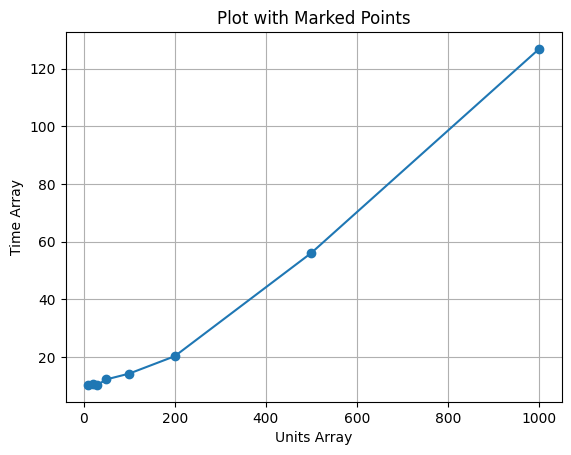

In [11]:
plt.plot(units_arr, time_arr, marker='o', linestyle='-')  # 'o' marker style with solid line
plt.xlabel('Units Array')
plt.ylabel('Time Array')
plt.title('Plot with Marked Points')
plt.grid(True)  # Add grid lines
plt.show()